# BIOS 740: Homework 1
## Predicting Alzheimer's Disease Status Using Hippocampal Data
### Cassi Chen

Please read the README.md before going through this notebook!

## Imports

In [1]:
import os, re, glob
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
import pytorch_lightning as pl
from torchvision import models
import torchvision.transforms.functional as TF
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import CSVLogger
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Data Exploration and Preprocessing

### Preprocessing

Some useful constants.

In [2]:
# Optional: drop samples if nearest diagnosis is too far away (days). None = keep all.
MAX_DELTA_DAYS = None  # e.g., 180

# Parse files (ex. 002_S_0295__2006-05-09__S118671.5T.csv.gz)
FNAME_RE = re.compile(
    r"^(?P<ptid>\d+_S_\d+)__(?P<date>\d{4}-\d{2}-\d{2})__(?P<tag>.+?)\.csv(?:\.gz)?$" # NOTE: tag can contain dots; capture everything up to ".csv"
)

We write helper functions to help with preprocessing. First, file names that cannot be parsed are discarded. Samples without right and left files for the same subject, examdate, and tag are also discarded. This ensures are data is not corrupted and complete.

In [3]:
### Preprocess Data ###

# Parse filenames
def parse_fname(path: str):
    base = os.path.basename(path)
    m = FNAME_RE.match(base)
    if not m:
        return None
    return m.group("ptid"), m.group("date"), m.group("tag"), base # (PTID, EXAMDATE, TAG)

# Match left/right scans into paired samples
def build_paired_samples(left_dir: str, right_dir: str) -> pd.DataFrame:
    left_files  = glob.glob(os.path.join(left_dir, "*.csv")) + glob.glob(os.path.join(left_dir, "*.csv.gz"))
    right_files = glob.glob(os.path.join(right_dir, "*.csv")) + glob.glob(os.path.join(right_dir, "*.csv.gz"))

    # key by (PTID, EXAMDATE, TAG) instead of basename (more robust)
    left_map = {}
    for p in left_files:
        parsed = parse_fname(p)
        if not parsed:
            continue
        ptid, date, tag, _ = parsed
        left_map[(ptid, date, tag)] = p

    right_map = {}
    for p in right_files:
        parsed = parse_fname(p)
        if not parsed:
            continue
        ptid, date, tag, _ = parsed
        right_map[(ptid, date, tag)] = p

    common_keys = sorted(set(left_map) & set(right_map))

    rows = []
    for (ptid, date, tag) in common_keys:
        rows.append({
            "PTID": ptid,
            "EXAMDATE_FILE": date,
            "TAG": tag,
            "LeftFile": left_map[(ptid, date, tag)],
            "RightFile": right_map[(ptid, date, tag)],
        })
    return pd.DataFrame(rows) # Dataframe(PTID, EXAMEDATE, TAG, LEFT, RIGHT)

Next, we normalize the labels to ensure consistency across diagnosis. This helps stability in the model. We also drop all labels with missing exam dates or label names to handle missing data. Finally, we drop all duplicates to remove redundency.

In [4]:
### Preprocess Labels ###

# Normalize labels
def normalize_dx(dx: str):
    if pd.isna(dx):
        return None
    dx = str(dx).strip()
    if dx == "":
        return None
    u = dx.upper()
    if u in {"CN", "NC", "SMC"}:
        return "CN"
    if u in {"MCI", "EMCI", "LMCI"} or "MCI" in u:
        return "MCI"
    if u in {"AD", "DEMENTIA"} or "DEMENT" in u:
        return "AD"
    return None

# Build lookup table of diagnoisis
def build_dx_index(adnimerge_csv: str):
    df = pd.read_csv(adnimerge_csv, dtype=str)
    if "PTID" not in df.columns or "EXAMDATE" not in df.columns:
        raise ValueError("ADNIMERGE must have PTID and EXAMDATE.")

    dx_col = "DX" if "DX" in df.columns else ("DX_bl" if "DX_bl" in df.columns else None)
    if dx_col is None:
        raise ValueError("ADNIMERGE has neither DX nor DX_bl.")

    df = df[["PTID", "EXAMDATE", dx_col]].copy()
    df["EXAMDATE"] = pd.to_datetime(df["EXAMDATE"], errors="coerce")
    df["DX_NORM"] = df[dx_col].apply(normalize_dx) # normalize labels
    df = df.dropna(subset=["EXAMDATE", "DX_NORM"])

    out = {}
    for ptid, g in df.groupby("PTID"):
        gg = g[["EXAMDATE", "DX_NORM"]].drop_duplicates().sort_values("EXAMDATE").reset_index(drop=True)
        out[ptid] = gg
    return out # {PTID: Dataframe(EXAMDATE, DR_NORM)}

Now, we now match the normalized labels to the data. Sometimes, there is no exact match between scan exam dates and label exam dates. We handle this with nearest-date matsching for each scan. Optional: We reject labels if they are too far from the scan date to ensure quality control.

In [5]:
# Match labels to data
def match_dx_for_sample(ptid: str, examdate_str: str, dx_index, max_delta_days=None):
    examdate = pd.to_datetime(examdate_str, errors="coerce")
    if pd.isna(examdate) or ptid not in dx_index or dx_index[ptid].empty:
        return None, None, None

    g = dx_index[ptid]
    exact = g[g["EXAMDATE"] == examdate]
    if not exact.empty:
        return exact.iloc[0]["DX_NORM"], examdate, 0

    deltas = (g["EXAMDATE"] - examdate).abs() # Comparing Data EXAMDATE to the many Label EXAMDATES
    i = int(deltas.idxmin())
    matched_date = g.loc[i, "EXAMDATE"]
    dx = g.loc[i, "DX_NORM"]
    delta_days = int(abs((matched_date - examdate).days))

    if max_delta_days is not None and delta_days > max_delta_days:
        return None, matched_date, delta_days
    return dx, matched_date, delta_days # (dx, matched_date, delta_days)

Finally, we can utilize all the helper functions to create a clean dataset. We only keep rows with AD or CN as as the diagnosis, as that is what we will be predicting on.

In [6]:
# Config
adnimerge_csv = "ADNIMERGE_01Oct2024.csv"
left_hippo_dir  = "LeftCSV_organized/"
right_hippo_dir = "RightCSV_organized/"

In [7]:
# Build all paired samples + label from nearest DX
samples_df = build_paired_samples(left_hippo_dir, right_hippo_dir) # Dataframe(PTID, EXAMEDATE, TAG, LEFT, RIGHT)

dx_index = build_dx_index(adnimerge_csv) # {PTID: Dataframe(EXAMDATE, DR_NORM)}

dx_list, matched_list, delta_list = [], [], []
for _, r in samples_df.iterrows():
    dx, mdate, delta = match_dx_for_sample(
        r["PTID"], r["EXAMDATE_FILE"], dx_index, max_delta_days=MAX_DELTA_DAYS
    )
    dx_list.append(dx)
    matched_list.append(mdate.strftime("%Y-%m-%d") if mdate is not None else None)
    delta_list.append(delta)

samples_df["DX_NORM"] = dx_list
samples_df["EXAMDATE_MATCHED"] = matched_list
samples_df["DELTA_DAYS"] = delta_list

# keep labeled only
samples_df = samples_df.dropna(subset=["DX_NORM"]).reset_index(drop=True)

label_order = ["CN", "AD", "MCI"]
label_to_index = {lab: i for i, lab in enumerate(label_order)}
samples_df["label_idx"] = samples_df["DX_NORM"].map(label_to_index).astype(int)

samples_df.to_csv("samples_with_dx_manifest.tsv", sep="\t", index=False)
# only keep AD and CN
samples_df = samples_df[samples_df["DX_NORM"].isin(["AD", "CN"])].reset_index(drop=True)

print("------Checking Samples------")
print("[INFO] Paired samples:", samples_df.shape[0])
print(samples_df["DX_NORM"].value_counts())

samples_df


[INFO] Paired samples: 3855
DX_NORM
CN    2397
AD    1458
Name: count, dtype: int64


,PTID,EXAMDATE_FILE,TAG,LeftFile,RightFile,DX_NORM,EXAMDATE_MATCHED,DELTA_DAYS,label_idx
0,002_S_0295,2006-05-09,S118671.5T,LeftCSV_organized/002_S_0295__2006-05-09__S118...,RightCSV_organized/002_S_0295__2006-05-09__S11...,CN,2006-05-09,0.0,0
1,002_S_0295,2006-11-02,S118692.5T,LeftCSV_organized/002_S_0295__2006-11-02__S118...,RightCSV_organized/002_S_0295__2006-11-02__S11...,CN,2006-11-02,0.0,0
2,002_S_0295,2007-05-25,S64025.5T,LeftCSV_organized/002_S_0295__2007-05-25__S640...,RightCSV_organized/002_S_0295__2007-05-25__S64...,CN,2007-05-25,0.0,0
3,002_S_0295,2008-08-04,S123685.5T,LeftCSV_organized/002_S_0295__2008-08-04__S123...,RightCSV_organized/002_S_0295__2008-08-04__S12...,CN,2008-08-04,0.0,0
4,002_S_0295,2011-06-02,S110477,LeftCSV_organized/002_S_0295__2011-06-02__S110...,RightCSV_organized/002_S_0295__2011-06-02__S11...,CN,2011-06-02,0.0,0
...,...,...,...,...,...,...,...,...,...
3850,941_S_6058,2019-08-14,S859289,LeftCSV_organized/941_S_6058__2019-08-14__S859...,RightCSV_organized/941_S_6058__2019-08-14__S85...,CN,2019-08-14,0.0,0
3851,941_S_6333,2019-06-28,S837664,LeftCSV_organized/941_S_6333__2019-06-28__S837...,RightCSV_organized/941_S_6333__2019-06-28__S83...,CN,2019-05-14,45.0,0
3852,941_S_6345,2019-05-29,S827415,LeftCSV_organized/941_S_6345__2019-05-29__S827...,RightCSV_organized/941_S_6345__2019-05-29__S82...,AD,2019-05-15,14.0,1
3853,941_S_6575,2019-09-16,S873646,LeftCSV_organized/941_S_6575__2019-09-16__S873...,RightCSV_organized/941_S_6575__2019-09-16__S87...,CN,2019-09-16,0.0,0


### Data Loading

Lets create a custom PyTorch dataset for the cleaned data. To read the scan data, we decompress and load the CSV file containing the hippocompal matrices with Pandas. The data is in the shape (15000, 7), corresponding to 15000 spatial locations and 7 feature channels. Since there are left and right matrices, we concatenate them for to get (15000, 14) without losing any information. We can then reshape this to (14, 150, 100) and convert it into a tensor so that it can be run in through a neural network. We also standardize across the 14 channels over the 150 x 100 spatial dimensions to help with convergence during training.

In [8]:
class HippocampusDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df.reset_index(drop=True)
        self.subject_ids = self.df["PTID"].tolist()

    def __len__(self):
        return self.df.shape[0]

    def _read_matrix(self, path: str) -> np.ndarray:
        return pd.read_csv(path, header=None, sep=r"\s+", engine="python").values # .gz handled automatically by pandas

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        left  = self._read_matrix(row["LeftFile"]).astype(np.float32)   # (15000, 7)
        right = self._read_matrix(row["RightFile"]).astype(np.float32)  # (15000, 7)

        ##########################################################
        # 1. Concatenate the left and right hippocampus data along the feature dimension => (15000, 14)
        # 2. Transpose to get (14, 15000)
        # 3. Reshape each feature into (14, 150, 100)
        # 4. Convert to torch tensor and normalize per feature channel
        ##########################################################

        # Step 1: Concatenate (15000, 7) --> (15000,14)
        sample = np.concatenate([left, right], axis=1)

        # Step 2: Transpose to (14, 15000)
        sample = sample.T

        # Step 3: Reshape each feature to (14, 150, 100)
        sample = sample.reshape(14, 150, 100)

        # Step 4a: Convert to PyTorch tensor
        sample = torch.from_numpy(sample)

        # Step 4b: Normalize each feature channel
        mean = sample.mean(dim=(1,2), keepdim=True) # (14, 1, 1)
        std = sample.std(dim=(1,2), keepdim=True) # (14, 1, 1)
        sample = (sample - mean)/std # (14, 150, 100)

        ##########################################################
        # END OF YOUR CODE
        ##########################################################

        label = int(row["label_idx"])
        return sample, label

## Model Development

### CNN Architecture Design

Inputs are of shape  [B, 14, 150, 100], where B is batch size, 14 is feature channels, and 150 x 100 is the spatial dimension.

Number and types of layers:
- Convolution: 3 total
    - extract hierarchical features
    - increase channels to learn more complex feature (32 --> 64 --> 128)
- Pooling: 3 total, 1 after each convolution and ReLU
    - reduce data dimensionality
    - Max Pooling: (2x2) halves spatial dimension
- Fully Connected: 2 total at the end
    - prepare for classification

Kernel, Stride, an Padding (same for all convolution blocks): 
- Kernel Sizes: 3x3
    - odd number to preserve dimensionaity with padding
    - small size to catch local patterns 
- Strides: 1 
    - kernel moves 1 position at a time to ensure all inputs are examined
- Padding: 1
    - ensures features near edge of data to be included by adding a one-border pixel
    - preserve spatial dimension with the given kernel size and strides

Activation Functions:
- ReLU: 3 total, 1 after each batch normalization and fully connected layer
    - introduces non-linearity
    - prevents vanishing gradients

Regularization Techniques: 
- Dropout: 1 total, 1 before fully connected layers
    - prevents overfitting
    - rate: 0.3
- Batch Normalization: 3 total, 1 after each convolution
    - stabalize training

Size Summary: 

    CONVOLUTION BLOCK 1
    Conv1: [B, 32, 150, 100]
    Bn1: [B, 32, 150, 100]
    ReLU: [B, 32, 150, 100]
    Pool1: [B, 32,  75,  50]

    CONVOLUTION BLOCK 2
    Conv2: [B, 64,  75,  50]
    Bn2: [B, 64,  75,  50]
    ReLU: [B, 64,  75,  50]
    Pool2: [B, 64,  37,  25]

    CONVOLUTION BLOCK 3
    Conv3: [B, 128, 37,  25]
    Bn3: [B, 128, 37,  25]
    ReLU: [B, 128, 37,  25]
    Pool3: [B, 128, 18,  12]

    Flatten: [B, 128*18*12]

    Fc1: [B, 256]
    ReLU: [B, 256]
    Dropout: [B, 256]
    Fc2: [B, 2]

We end with class scores for AD or CN.

### Implementation

First, a trainer.

In [9]:
class Trainer(pl.LightningModule):
    def __init__(self, model = None):
        super(Trainer, self).__init__()
        self.model = model
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self, x):  
        return self.model(x)
        
    def training_step(self, batch, batch_idx):
        data, labels = batch
        outputs = self(data)
        loss = self.criterion(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        acc = (preds == labels).float().mean()
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        return loss

    def validation_step(self, batch, batch_idx):
        data, labels = batch
        outputs = self(data)
        loss = self.criterion(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        acc = (preds == labels).float().mean()
        self.log('val_loss', loss)
        self.log('val_acc', acc)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

We can actually calculate the output after all 3 convolution blocks. We can use this information when writing out the CNN. This will be helpful in figuring out the input size for the fully connected layers.

In [10]:
def calculate_output_shape(height, width):
    """
    Helper to compute output (height, width) after convolution block
    """
    for _ in range(3):
        # Conv layer
        height = ((height + 2*1 - (3 - 1) - 1) // 1) + 1 # out = (in + 2 * pad - dil(kern-1) -1/ stride) + 1
        width  = ((width  + 2*1 - (3 - 1) - 1) // 1) + 1
        # Pool layer
        height = ((height - (2 - 1) - 1) // 2) + 1 # out =  (in - (kern-1) -1/ stride) + 1
        width  = ((width  - (2 - 1) - 1) // 2) + 1
    
    return height, width
calculate_output_shape(150, 100)

(18, 12)

Now for the actual CNN implementation with PyTorch.

In [11]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        ##########################################################
        # 1) Three 2D convolutional layers
        # 2) A MaxPool2d layer self.pool
        # 3) A Dropout layer self.dropout with probability 0.5
        # 4) Two fully connected layers
        #    -> Remember to compute in_features for self.fc1 based on
        #       the output shape after the Conv+Pool layers.
        ##########################################################

        # Conv2d: in_channels=14  (since your data has shape [B, 14, 150, 100])
        #          out_channels=32/64/128
        #          kernel_size=3, stride=1, padding=1 (typical “same” conv)
        self.conv1 = nn.Conv2d(in_channels=14, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # MaxPool2d: kernel_size=2, stride=2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dropout
        self.dropout = nn.Dropout(0.3)

        # Compute the spatial output size after 3 conv+pool layers
        out_h, out_w = calculate_output_shape(150, 100)

        # Fully Connected layers
        # After the last conv/pool, you have 128 channels with size out_h x out_w
        self.fc1 = nn.Linear(128 * out_h * out_w, 256) # 256 is hidden size
        self.fc2 = nn.Linear(256, num_classes)

        ##########################################################
        # END OF YOUR CODE
        ##########################################################

    def forward(self, x):
        """
        Forward pass:
        x shape = [batch_size, 14, 150, 100]
        """
        # 1) First conv + ReLU + pool
        x = F.relu(self.bn1(self.conv1(x)))  # [B, 32, 150, 100]
        x = self.pool(x)           # [B, 32,  75,  50]

        # 2) Second conv + ReLU + pool
        x = F.relu(self.bn2(self.conv2(x)))  # [B, 64,  75,  50]
        x = self.pool(x)           # [B, 64,  37,  25]

        # 3) Third conv + ReLU + pool
        x = F.relu(self.bn3(self.conv3(x)))  # [B, 128, 37,  25]
        x = self.pool(x)           # [B, 128, 18,  12]

        # Flatten
        x = x.view(x.size(0), -1)  # [B, 128*18*12]
        x = self.dropout(x)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x.squeeze()  

We can run a quick test on the model.

In [12]:
print("------Checking SimpleCNN------")
model1 = SimpleCNN(num_classes=2)
model1.eval()
x = torch.randn(2, 14, 150, 100)
with torch.no_grad():
    y = model1(x)

print("Output shape:", y.shape)
print("Output tensor:", y)

Output shape: torch.Size([2, 2])
Output tensor: tensor([[ 0.0800, -0.1121],
        [ 0.0843, -0.1354]])


### Adopt Modern CNN Architectures like ResNet, VGG

We recreate Resnet18 from scratch. Code inspired from https://github.com/priyammaz/PyTorch-Adventures, where I followed all the tutorials 2 years ago to learn all the architectures. We implement an extra convolution in the beginning.

In [13]:
class ResidualBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1, downsample=None, residual=True):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(planes)

        self.relu = nn.ReLU()
        self.downsample = downsample
        self.residual = residual

    def forward(self, x):
        identity = x

        x = self.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))

        if self.residual:
            if self.downsample is not None:
                identity = self.downsample(identity)
            x = x + identity
        
        x = self.relu(x)

        return x

In [14]:
class SimpleResNet(nn.Module):
    def __init__(self, layer_counts, num_channels=14, num_classes=2, residual=True):
        super(SimpleResNet, self).__init__()

        self.residual = residual
        self.inplanes = 32 

        # Extra convolution
        self.conv0 = nn.Conv2d(14, 14, kernel_size=3, stride=1, padding=1)
        self.bn0 = nn.BatchNorm2d(14)

        # Initial convolution
        self.conv1 = nn.Conv2d(14, self.inplanes, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Layers
        self.layer1 = self._make_layers(layer_counts[0], planes=64, stride=1)
        self.layer2 = self._make_layers(layer_counts[1], planes=128, stride=2)
        self.layer3 = self._make_layers(layer_counts[2], planes=256, stride=2)
        self.layer4 = self._make_layers(layer_counts[3], planes=512, stride=2)
        
        # Pooling and Classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(10240, 256)  # 128 channels after adaptive pooling
        self.fc2 = nn.Linear(256, num_classes)

    def _make_layers(self, num_residual_blocks, planes, stride):
        downsample = None
        layers = nn.ModuleList()
        
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
        nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride, bias=False),
        nn.BatchNorm2d(planes)
    )

        layers.append(ResidualBlock(in_planes=self.inplanes,
                                    planes=planes, 
                                    stride = stride,
                                    downsample=downsample,
                                    residual=self.residual))
        self.inplanes = planes
        
        for _ in range(num_residual_blocks - 1):
            layers.append(
                ResidualBlock(
                    in_planes=self.inplanes, 
                    planes = planes,
                    residual=self.residual
                )
            )

        return nn.Sequential(*layers)


    def forward(self, x): # [B, 14, 150, 100]

        x = self.relu(self.bn0(self.conv0(x))) # [B, 14, 150, 100]

        x = self.maxpool(self.relu(self.bn1(self.conv1(x)))) # [B, 32, 38, 25]

        x = self.layer1(x) # [B, 64, 38, 25]
        x = self.layer2(x) # [B, 128, 19, 13]
        x = self.layer3(x) # [B, 256, 10, 7]
        x = self.layer4(x) # [B, 512, 5, 4]

        x = torch.flatten(x,1) # [B, 10240]
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # [B, 2]

        return x

We can run a quick test on the model.

In [15]:
print("------Checking SimpleResNet------")
layer_counts = [2, 2, 2, 2]
model2 = SimpleResNet(layer_counts=layer_counts, num_channels=14, num_classes=2)
model2.eval()
x = torch.randn(2, 14, 150, 100)
with torch.no_grad():
    y = model2(x)

print("Output shape:", y.shape)
print("Output tensor:", y)

Output shape: torch.Size([2, 2])
Output tensor: tensor([[ 0.0023, -0.0459],
        [ 0.0015, -0.0468]])


## Training and Validation

### Data Splitting

We do a train-val-test split of 80-10-10. This is because we want as much data as possible to train the model, but we still want enough data for valitation and testing. 

In [16]:
# Split by subject (PTID) to avoid leakage across timepoints
groups = samples_df["PTID"].values
gss1 = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, temp_idx = next(gss1.split(samples_df, groups=groups))

train_df = samples_df.iloc[train_idx].reset_index(drop=True)
temp_df  = samples_df.iloc[temp_idx].reset_index(drop=True)

gss2 = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx, test_idx = next(gss2.split(temp_df, groups=temp_df["PTID"].values))

val_df  = temp_df.iloc[val_idx].reset_index(drop=True)
test_df = temp_df.iloc[test_idx].reset_index(drop=True)

train_dataset = HippocampusDataset(train_df)
val_dataset   = HippocampusDataset(val_df)
test_dataset  = HippocampusDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=16, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

We can actually take a look at our training data too. Lets also visualize 1 sample.

The training set contain 3081 samples.
Each sample has shape torch.Size([14, 150, 100]).


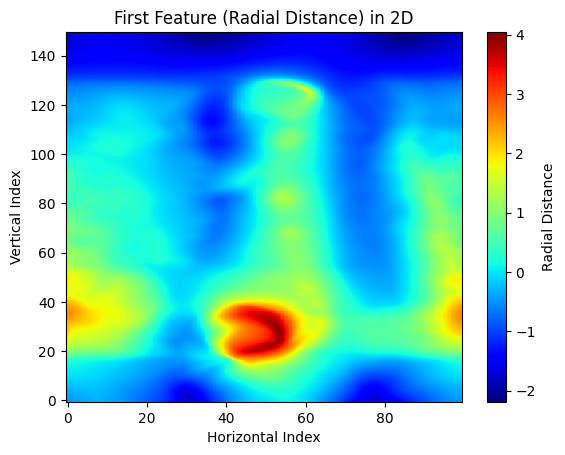

In [17]:
print("------Checking DataLoader Samples------")
print(f"The training set contain {len(train_dataset)} samples.")
print(f"Each sample has shape {train_dataset[0][0].shape}.")

example_rd_tensor = train_dataset[0][0][0]  # shape: (150, 100) # Essentially looks at 1st sample, 1st tensor, 1st channel
# Convert to NumPy
radial_distance = example_rd_tensor.cpu().numpy() 

# Then plot as before
plt.imshow(radial_distance, origin='lower', cmap='jet', aspect='auto')
plt.colorbar(label="Radial Distance")
plt.title("First Feature (Radial Distance) in 2D")
plt.xlabel("Horizontal Index")
plt.ylabel("Vertical Index")
plt.savefig("sample.png", dpi=300, bbox_inches='tight')
plt.show()

### Model Training

We can use callback to monitor the training and validation loss and acuracy over epochs. The metrics will be plotted.

In [18]:
# Track training and validation progress

class FinalPlotCallback(pl.Callback):
    def __init__(self, name="Model"):
        super().__init__()
        self.name = name
        self.train_losses = []
        self.val_losses = []
        self.train_accs = []
        self.val_accs = []

    def on_train_epoch_end(self, trainer, pl_module):
        # Append training and validation loss at the end of each epoch
        train_loss = trainer.callback_metrics.get("train_loss")
        if train_loss:
            self.train_losses.append(train_loss.cpu().detach().item())
        
        val_loss = trainer.callback_metrics.get("val_loss")
        if val_loss:
            self.val_losses.append(val_loss.cpu().detach().item())
        
        # Append training and validation accuracy at the end of each epoch
        train_acc  = trainer.callback_metrics.get("train_acc")
        if train_acc:
            self.train_accs.append(train_acc.cpu().detach().item())

        val_acc    = trainer.callback_metrics.get("val_acc")
        if val_acc:
            self.val_accs.append(val_acc.cpu().detach().item())

    def on_train_end(self, trainer, pl_module):

        # Plot the losses at the end of training
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label="Train Loss", marker="o")
        plt.plot(self.val_losses, label="Validation Loss", marker="o")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"Training and Validation Loss Over Epochs ({self.name})")
        plt.legend()
        plt.grid(True)
        plt.savefig(f"train_val_loss_{self.name}.png", dpi=300, bbox_inches='tight')
        plt.show()

        # Plot accuracies at the end of training
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_accs, label="Train Accuracy", marker="o")
        plt.plot(self.val_accs, label="Validation Accuracy", marker="o")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title(f"Training and Validation Accuracy Over Epochs ({self.name})")
        plt.legend()
        plt.grid(True)
        plt.savefig(f"train_val_acc_{self.name}.png", dpi=300, bbox_inches='tight')
        plt.show()

Now we can finally train both models.

/nas/longleaf/home/cxchen/.local/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nas/longleaf/home/cxchen/.local/lib/python3.9/site- ...
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
/nas/longleaf/home/cxchen/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the

------Training SimpleCNN------
Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/nas/longleaf/home/cxchen/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: 100%|██████████| 193/193 [08:09<00:00,  0.39it/s, v_num=20]       

`Trainer.fit` stopped: `max_epochs=1` reached.


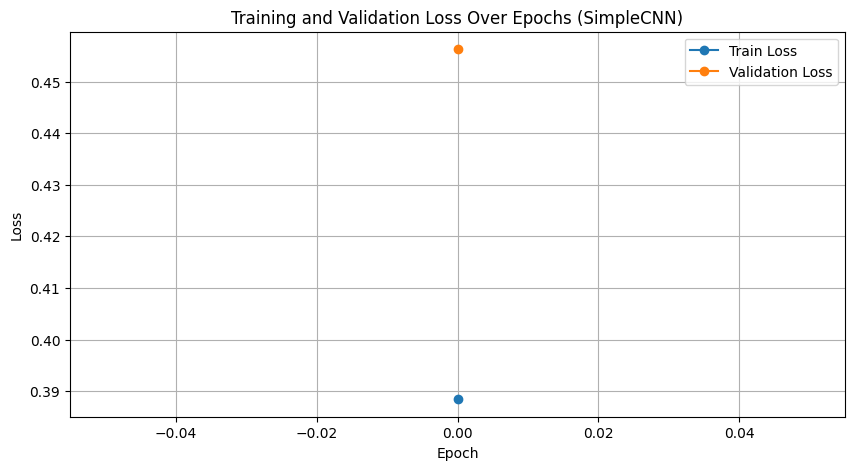

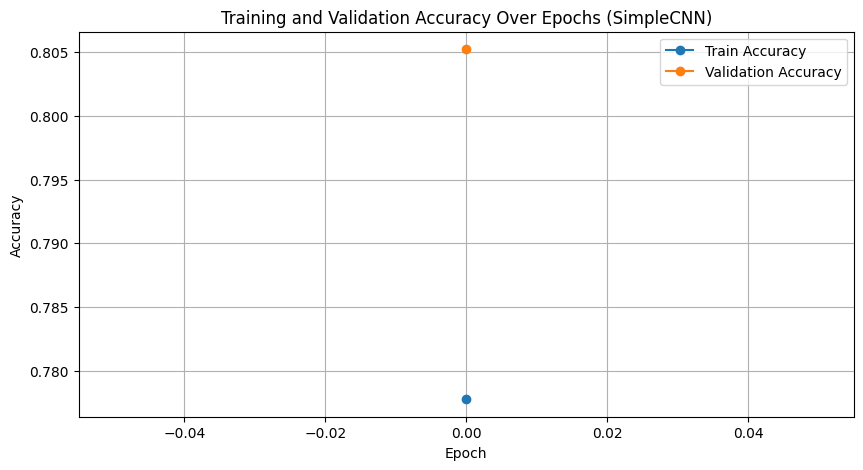

Epoch 0: 100%|██████████| 193/193 [08:10<00:00,  0.39it/s, v_num=20]


In [ ]:
# CNN
print("------Training SimpleCNN------")
model1 = Trainer(model=SimpleCNN())
model_name_1 = type(model1.model).__name__

# Trainer
trainer1 =  pl.Trainer(max_epochs=50, 
                        default_root_dir="/nas/longleaf/home/cxchen/BIOS740/hw1",
                        callbacks=[FinalPlotCallback(name=model_name_1), EarlyStopping(monitor='val_loss', patience=5)])
# Training
trainer1.fit(model1, train_loader, val_loader)

In [ ]:
# Resnet
print("------Training SimpleResNet------")
model2 = Trainer(model=SimpleResNet(layer_counts=[2,2,2,2]))
model_name_2 = type(model2.model).__name__
# Trainer
trainer2 =  pl.Trainer(max_epochs=50,
                        default_root_dir="/nas/longleaf/home/cxchen/BIOS740/hw1",
                        callbacks=[FinalPlotCallback(name=model_name_2), EarlyStopping(monitor='val_loss', patience=5)])
# Training
trainer2.fit(model2, train_loader, val_loader)

### Overfitting Prevention

During Training:
- Early Stopping: stop training when validation loss doesn't improve
    - avoids training on unecessary epochs
    - patience: 5

Model Architecture:
- Pooling: reduce data dimensionality
    - helps with generalization
    - Max Pooling: (2x2) halves spatial dimension
- Dropout: randomly zeros neurons on each forward pass
    - prevents model from memorizing training data
    - rate: 0.3
- Batch Normalization: normalizes across batch
    - stabalizes training

## Model Evaluation

### Performance Metrics

We now need to evaluate both models on the validation set. We use accuracy. precision, recall, f1-score, and roc-auc curve.

In [20]:
# Evaluate the model 
def evaluation(model, test_loader, class_names=("CN","AD")):
    """
    Multi-class evaluation (CN/AD) with weighted metrics + macro metrics.
    Computes ROC-AUC using softmax probabilities (OVR).
    """
    model.eval()

    y_true = []
    y_pred = []
    y_prob = []

    with torch.no_grad():
        for data, labels in test_loader:
            logits = model(data)

            # Fix batch_size==1 squeeze issue: [2] -> [1,2]
            if logits.dim() == 1:
                logits = logits.unsqueeze(0)

            if logits.dim() != 2:
                raise ValueError(f"Unexpected logits shape {tuple(logits.shape)}; expected [B, C].")

            C = logits.shape[1]
            if C != 2:
                raise ValueError(
                    f"Model outputs C={C} classes, but binary testing expects 2. "
                    f"Make sure SimpleCNN(num_classes=2) and the final layer matches CN/AD."
                )

            probs = torch.softmax(logits, dim=1)      # [B,2]
            pred  = torch.argmax(probs, dim=1)        # [B]

            y_true.extend(labels.cpu().numpy().tolist())
            y_pred.extend(pred.cpu().numpy().tolist())
            y_prob.extend(probs[:, 1].cpu().numpy().tolist())  # P(AD)

    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    y_prob = np.asarray(y_prob)
    ##########################################################
    # TODO: Import the necessary evaluation metrics from sklearn.metrics:
    # - accuracy_score
    # - precision_score
    # - recall_score
    # - f1_score
    # - roc_auc_score
    #
    # Then, compute the following metrics using `test_label` and `test_preds`:
    # 1. Accuracy
    # 2. Precision (use 'weighted' average)
    # 3. Recall (use 'weighted' average)
    # 4. F1-Score (use 'weighted' average)
    # 5. ROC-AUC (use 'weighted' average and 'ovr' for multi_class)
    #
    # Finally, print out each metric with four decimal places in the specified format.
    ##########################################################
    # Replace "pass" statement with your code

    from sklearn.metrics import (
        accuracy_score, precision_score, recall_score, f1_score,
        roc_auc_score, classification_report, confusion_matrix
    )
        # Core metrics
    acc = accuracy_score(y_true, y_pred)
    prec_w = precision_score(y_true, y_pred, average='weighted')
    rec_w  = recall_score(y_true, y_pred, average='weighted')
    f1_w   = f1_score(y_true, y_pred, average='weighted')

    # Optional: macro metrics (nice to report for imbalance)
    prec_m = precision_score(y_true, y_pred, average='macro')
    rec_m  = recall_score(y_true, y_pred, average='macro')
    f1_m   = f1_score(y_true, y_pred, average='macro')

    # ROC-AUC (multi-class): needs probabilities, not predicted labels
    # If a class is missing in y_true for this split, roc_auc_score can error.
    roc_auc = None
    try:
        roc_auc = roc_auc_score(y_true, y_prob, average='weighted', multi_class='ovr')
    except ValueError as e:
        print(f"[WARN] ROC-AUC not computed: {e}")

    print(f"Test Accuracy:   {acc:.4f}")
    print(f"Test Precision(w): {prec_w:.4f}")
    print(f"Test Recall(w):    {rec_w:.4f}")
    print(f"Test F1(w):        {f1_w:.4f}")
    if roc_auc is not None:
        print(f"Test ROC-AUC(w, ovr): {roc_auc:.4f}")

    # Extra diagnostics - confusion matrix + full classification report
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(set(y_true))))) #labels=[0,1]
    print("\nConfusion Matrix (rows=true, cols=pred):")
    print(cm)

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, labels=[0,1], target_names=["CN","AD"], digits=4, zero_division=0))

    # Return values as a dictionary
    return {
        "accuracy": acc,
        "precision_weighted": prec_w,
        "recall_weighted": rec_w,
        "f1_weighted": f1_w,
        "precision_macro": prec_m,
        "recall_macro": rec_m,
        "f1_macro": f1_m,
        "roc_auc_weighted_ovr": roc_auc
    }

    ##########################################################
    # END OF YOUR CODE
    ##########################################################

In [21]:
print("------Evaluating SimpleCNN------")
evaluation(model1, val_loader)

print("------Evaluating SimpleResNet------")
evaluation(model2, val_loader)

------Evaluating SimpleCNN------


/nas/longleaf/home/cxchen/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Test Accuracy:   0.8052
Test Precision(w): 0.8065
Test Recall(w):    0.8052
Test F1(w):        0.8058
Test ROC-AUC(w, ovr): 0.8534

Confusion Matrix (rows=true, cols=pred):
[[227  43]
 [ 39 112]]

Classification Report:
              precision    recall  f1-score   support

          CN     0.8534    0.8407    0.8470       270
          AD     0.7226    0.7417    0.7320       151

    accuracy                         0.8052       421
   macro avg     0.7880    0.7912    0.7895       421
weighted avg     0.8065    0.8052    0.8058       421



{'accuracy': 0.8052256532066508,
 'precision_weighted': 0.806468435282521,
 'recall_weighted': 0.8052256532066508,
 'f1_weighted': 0.8057719182022911,
 'precision_macro': 0.7879820519039534,
 'recall_macro': 0.7912312975226883,
 'f1_macro': 0.789520534581992,
 'roc_auc_weighted_ovr': np.float64(0.8533971057149865)}

### Results Interpretation

Full metric report can be found in the slurm-__.out file. 

Useful Formulas and Notes: Let F be False, T be True, N be negative, P be positive

Confusion Matrix:
[TN FP]
[FN TP]
- High FN -> Missclassify many P
- High FP -> Missclassify many N

- Accuracy = (TP+TN)/(TP+TN+FP+FN) Higher -> fewer total mistakes
- Specificity = TN/(TN+FP) Higher -> fewer FP
- Precision: TP/(TP+FP) Higher -> fewer FP
- Sensitivity/Recall = TP/(TP+FN) Higher -> fewer FN
- F1 = 2 * (Precision x Recall)/(Precision+Recall) = (2 x TP)/(2 x TP+FP+FN) Higher -> better tradeoff between precision and recall
- ROC-AUC = \int_0^{1}TP x FPdFR Higher -> better discrimination power


SimpleCNN: 
- Performance: 
    - Confusion Matrix: [[256  14]
                        [ 67  84]]
    - High FN -> Missclassify many P
- Strengths: Weighted Evaluation metrics are all very high, which are good based on the notes above.
    - Accuracy: 0.8076
    - Precision: 0.8157
    - Recall: 0.8076
    - F1: 0.7957
    - ROC-AUC: 0.8927
- Weaknesses: The following metrics for AD were not very high, which are not good based on the notes above. 
    - AD Recall: 0.5563
    - AD f1-score: 0.6747

SimpleResNet:
- Performance: 
    - Confusion Matrix: [[262   8]
                        [ 98  53]]
    - High FN -> Missclassify many P
- Strengths: Weighted Evaluation metrics are ok, which are good based on the notes above.
    - Accuracy: 0.7482
    - Precision: 0.7784
    - Recall: 0.7482
    - F1: 0.7128
    - ROC-AUC: 0.8358
- Weaknesses: The following metrics for AD were not very high, which are not good based on the notes above. 
    - AD Recall: 0.3510
    - AD f1-score: 0.5000

Summary: SimpleCNN outperforms SimpleResNet in almost every metric. In both models, performance is dominated by CN, implying class imbalance. However, SimpleCNN appears more balance due to lower FN and better AD metrics.

## Test Set Prediction

### Inference

Finally, lets run the models on our test data.

In [22]:
def testing(model, test_dataset, test_loader, subject_ids):
    """
    Run model inference on the test set and return predicted labels.
    """
    model.eval()
    preds = []

    with torch.no_grad():
        for data, labels in test_loader:
            logits = model(data)
            if logits.dim() == 1:
                logits = logits.unsqueeze(0)
            if logits.dim() != 2:
                raise ValueError(f"Unexpected logits shape {tuple(logits.shape)}; expected [B, C].")

            C = logits.shape[1]
            if C != 2:
                raise ValueError(
                    f"Model outputs C={C} classes, but binary testing expects 2. "
                    f"Make sure SimpleCNN(num_classes=2) and the final layer matches CN/AD."
                )
            probs = torch.softmax(logits, dim=1)
            pred  = torch.argmax(probs, dim=1)
            preds.extend(pred.cpu().numpy().tolist())

    predictions = pd.DataFrame({
        "SubjectID": subject_ids,
        "PredictedLabel": preds
    })

    return predictions

In [23]:
print("------Testing SimpleCNN------")
predictions1 = testing(model1, test_dataset, test_loader, test_dataset.subject_ids)

print("------Testing SimpleResNet------")
predictions2 = testing(model2, test_dataset, test_loader, test_dataset.subject_ids)

------Testing SimpleCNN------


/nas/longleaf/home/cxchen/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


### Submission File

Now lets save the predictions to a CSV file.

In [24]:
predictions1.to_csv("hw1_SimpleCNN.csv", index=False)
predictions2.to_csv("hw1_SimpleResNet.csv", index=False)

## Discussion and Conclusion

### Biomedical Implications

Interpretation: 

Using hippocampal data, SimpleCNN and SimpleResNet were both able to distinguish CN and AD from eachother. However, based on the evaluation metrics, SimpleCNN proves to be overall better. Compared to SimpleResNet, SimpleCNN has a higher recall (67 vs 98), meaning that there are fewer FN. This is extremely crucial in AD diagnosis, as failing to identify an affect patient can delay treatment. This may be due to the skip connection in ResNet that may be causing it to ignore AD features. Overall, SimpleCNN seems to be more effective an appropriate in AD detection. 

Contributions:  

The following references https://pmc.ncbi.nlm.nih.gov/articles/PMC8807768/.

Hippocampal structures contribute to AD prediction. Hoppocampal is one part of the brain that is affected by Alzheimers (AD). During the AD early stage, the hippocampus can show loss of tissue, implying a disconnection from other parts of the brain. As AD progresses, lack of sirtuin expression in hippocampal neuons will also impact cognitive function. We can use imaging techniques (including SimpleCNN and SimpleResNet) to look for features such as the loss of tissue and lack of sirtuin expression in order to make a AD prediction. Early detection means earlier interventions and treatment. 

### Challenges and Limitations

Difficulties: 

The biggest difficulty encounted during this assignment was dealing with class imbalance, where there are more CN (2397) than AD (1458) samples. This resulted in both the SimpleCNN and SimpleResNet to predict majority CN class, reducing recall for AD. This was extremely aparent in the SimpleResNet model, predicting AD subjects more incorrectly than correctly (98 vs 53). This may be due to the fact that deeper architectures may need more data to generlize well. It may also be because of the skip connect in ResNet allowing it to ignore certain AD features. 


Improvements/Alternative Approaches:   

- Class Imbalance handing: Get more AD cases to even out CN vs AD. 
- Model Selection: Use other simple architetures to improve the generalization over the dataset. Could also try a 3D CNN. 